<a href="https://colab.research.google.com/github/gremlin97/Turion/blob/main/SegNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gdown
!gdown --id 1S_qPoxgGNiDVtjDytY62f1Vk5WSyr4OJ
!unzip -q Final_dataset.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S_qPoxgGNiDVtjDytY62f1Vk5WSyr4OJ
To: /content/Final_dataset.zip
100% 2.53G/2.53G [00:21<00:00, 120MB/s] 


In [3]:
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!rm -rf /content/Final_dataset/images/train/.DS_Store

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

In [9]:
dir = '/content/Final_dataset'
transform = transforms.Compose([
                           transforms.Resize((256,256)),
                           transforms.ToTensor(),# Convert to Tensor,
                           transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                           transforms.RandomRotation(degrees=7)
                          #  transforms.Normalize((0.2212,), (0.2413,))
                           ])
# target_transform = transforms.Compose([
#                            transforms.Resize((256,256)),
#                            transforms.RandomHorizontalFlip(p=0.5),
#                            transforms.ToTensor(),# Convert to Tensor,
#                            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
#                            transforms.RandomRotation(degrees=7)
#                           #  transforms.Normalize((0.2212,), (0.2413,))
#                            ])

In [10]:
# Checking length of the training set and the corresponding masks
len(list(os.listdir(dir + '/images/train'))), len(list(os.listdir(dir + '/mask/train')))

(2517, 2517)

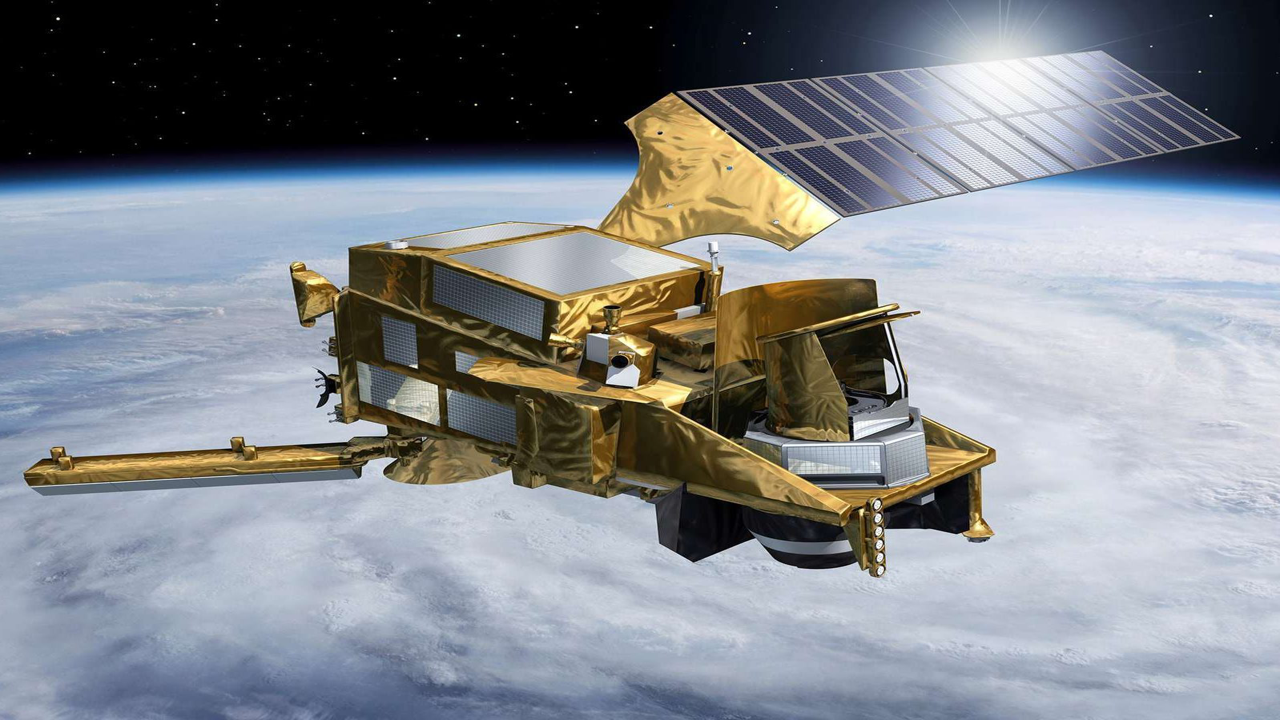

In [11]:
# Sampling an image from the training set
par_img_path = list(os.listdir(dir + '/images/train'))[0]
img_path = dir + '/images/train'+ '/' +par_img_path
img = Image.open(img_path)
img.show()

In [29]:
class SatelliteSeg(Dataset):
  def __init__(self, dir, transform, train=True):
    self.dir = dir
    # self.train_dir = dir + '/images/train'
    # self.train_mask = dir + '/mask/train'
    self.transform = transform

    if train:
      self.data_dir = dir + '/images/train'
      self.mask_dir = dir + '/mask/train'
    else:
      self.data_dir = dir + '/images/val'
      self.mask_dir = dir + '/mask/val'
    
  def __len__(self):
    self.img_path = list(os.listdir(self.data_dir))[:403]
    return len(self.img_path)

  def __getitem__(self, idx):
    img = self.data_dir + '/' + f'img_resize_{idx}.png'
    mask = self.mask_dir + '/' + f'img_resize_{idx}_mask.png'

    img = Image.open(img).convert('RGB')
    mask = Image.open(mask).convert('RGB')

    mask = mask.resize((256,256), resample=Image.NEAREST)

    mask_array = np.array(mask)
    label = torch.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=torch.uint8)
    label[(mask_array == np.array([255, 0, 0])).all(axis=2)] = 1  # red class
    label[(mask_array == np.array([0, 255, 0])).all(axis=2)] = 2  # green class
    label[(mask_array == np.array([0, 0, 255])).all(axis=2)] = 3  # blue class

    label = label.type(torch.LongTensor)
  
    if self.transform:
      img = self.transform(img)

    return img, label

train = SatelliteSeg(dir, transform)    

In [59]:
# val = SatelliteSeg(dir, transform, train=False)
# val_loader = DataLoader(val, batch_size=4, drop_last=True)

In [30]:
train_dir = dir + '/images/train'
img_path = list(os.listdir(train_dir))
img_path = img_path[0:402]
len(img_path)

402

In [31]:
img, mask = next(iter(train))
img.size(), mask.size()

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [32]:
torch.max(mask), type(mask)

(tensor(2), torch.Tensor)

In [33]:
len(train)

403

In [34]:
train_loader = DataLoader(train, batch_size=4, drop_last=True)

In [35]:
# Code to calculate train dataloader mean and std

# mean = 0.
# meansq = 0.
# for i, (data,mask) in enumerate(train_loader):
#     mean = data.mean()
#     meansq = (data**2).mean()

# std = torch.sqrt(meansq - mean**2)
# print("mean: " + str(mean))
# print("std: " + str(std))
# print()

In [36]:
imgs, masks = next(iter(train_loader))
imgs.size(), masks.size()

(torch.Size([4, 3, 256, 256]), torch.Size([4, 256, 256]))

In [37]:
class SegNext(nn.Module):
  def __init__(self):
    super().__init__()

    self.prep = nn.Sequential(
        nn.Conv2d(3,32,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(32)
    )

    self.prep_con = nn.Sequential(
        nn.Conv2d(32,32,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(32)
    )

    self.enc1 = nn.Sequential(
        nn.Conv2d(32,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    ) 

    self.enc1_con = nn.Sequential(
        nn.Conv2d(64,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )

    self.enc2 = nn.Sequential(
        nn.Conv2d(64,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128)
    )

    self.enc2_con = nn.Sequential(
        nn.Conv2d(128,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128)
    )

    self.enc3 = nn.Sequential(
        nn.Conv2d(128,256,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(256)
    )

    self.enc3_con = nn.Sequential(
        nn.Conv2d(256,256,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(256)
    )

    self.dec0 = nn.Sequential(
        nn.Conv2d(512,256,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.ConvTranspose2d(256,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128)
    )  

    self.dec1 = nn.Sequential(
        nn.Conv2d(256,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )  


    self.dec2 = nn.Sequential(
        nn.Conv2d(128,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64,32,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(32)
    )  

    self.final = nn.Sequential(
        nn.Conv2d(64,32,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.ConvTranspose2d(32,4,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(4)
    )

  def forward(self, x):
    in_size = x.size()
    x = self.prep(x)
    e1 = self.prep_con(x)
    x = self.enc1(e1)
    e2 = self.enc1_con(x)
    x = self.enc2(e2)
    e3 = self.enc2_con(x)
    x = self.enc3(e3)
    e4 = self.enc3_con(x)
    x = torch.cat((e4,x), 1)
    x = self.dec0(x)
    x = torch.cat((e3,x),1)
    x = self.dec1(x)
    x = torch.concat((e2,x),1)
    x = self.dec2(x)
    x = torch.concat((e1,x),1)
    x = self.final(x)

    return x

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
model = SegNext()

In [40]:
out = model(torch.rand(2,3,32,32))

In [41]:
from torchsummary import summary
summary(model.to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,928
             ReLU-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13          [-1, 128, 32, 32]          73,856
             ReLU-14          [-1, 128,

In [42]:
torch.cuda.empty_cache()

In [43]:
# from torch_lr_finder import LRFinder
# # define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=1, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

In [45]:
# define hyperparameters
lr = 1e-03
num_epochs = 50
batch_size = 4

# start training loop
for epoch in range(num_epochs):
    # set model to training mode
    model.train()

    # initialize loss and accuracy
    epoch_loss = 0.0
    epoch_acc = 0.0

    # loop over training batches
    for images, masks in train_loader:
        # send data to device
        images = images.to(device)
        masks = masks.to(device)

        # zero gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images)

        # calculate loss
        loss = criterion(outputs, masks)

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        # calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        # correct = (predicted == masks).all(dim=1).sum().item()
        # accuracy = correct / (batch_size * images.shape[2] * images.shape[3])

        # update epoch loss and accuracy
        epoch_loss += loss.item() * images.shape[0]
        # epoch_acc += accuracy * images.shape[0]

    # normalize epoch loss and accuracy
    epoch_loss /= len(train)
    epoch_acc /= len(train)

    # print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")  
    # , Train Acc: {epoch_acc:.4f}

Epoch 1/50, Train Loss: 1.1046
Epoch 2/50, Train Loss: 0.8289
Epoch 3/50, Train Loss: 0.6808
Epoch 4/50, Train Loss: 0.5935
Epoch 5/50, Train Loss: 0.5402
Epoch 6/50, Train Loss: 0.5057
Epoch 7/50, Train Loss: 0.4790
Epoch 8/50, Train Loss: 0.4581
Epoch 9/50, Train Loss: 0.4430
Epoch 10/50, Train Loss: 0.4298
Epoch 11/50, Train Loss: 0.4198
Epoch 12/50, Train Loss: 0.4149
Epoch 13/50, Train Loss: 0.4080
Epoch 14/50, Train Loss: 0.3997
Epoch 15/50, Train Loss: 0.3927
Epoch 16/50, Train Loss: 0.3858
Epoch 17/50, Train Loss: 0.3781
Epoch 18/50, Train Loss: 0.3762
Epoch 19/50, Train Loss: 0.3673
Epoch 20/50, Train Loss: 0.3679
Epoch 21/50, Train Loss: 0.3610
Epoch 22/50, Train Loss: 0.3598
Epoch 23/50, Train Loss: 0.3576
Epoch 24/50, Train Loss: 0.3486
Epoch 25/50, Train Loss: 0.3409
Epoch 26/50, Train Loss: 0.3379
Epoch 27/50, Train Loss: 0.3325
Epoch 28/50, Train Loss: 0.3330
Epoch 29/50, Train Loss: 0.3241
Epoch 30/50, Train Loss: 0.3236
Epoch 31/50, Train Loss: 0.3207
Epoch 32/50, Trai

In [88]:
import matplotlib.pyplot as plt
import numpy as np

def show_out(train,i):
    # Load an image and corresponding mask
    image, mask = train[i]

    image = image.to(device)
    mask = mask.to(device)

    # Apply the model to the image
    output = model(image.unsqueeze(0))

    # Get the predicted segmentation labels
    predicted_labels = output.argmax(dim=1)

    # Convert predicted labels to a numpy array
    predicted_labels_np = predicted_labels[0].cpu().numpy()

    # Display the input image, ground truth mask, and predicted mask
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

    # Plot input image
    ax[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
    ax[0].set_title('Input Image')

    # Plot ground truth mask
    ax[1].imshow(mask.squeeze().cpu().numpy())
    ax[1].set_title('Ground Truth Mask')

    # Plot predicted mask
    ax[2].imshow(predicted_labels_np)
    ax[2].set_title('Predicted Mask')
    plt.show()

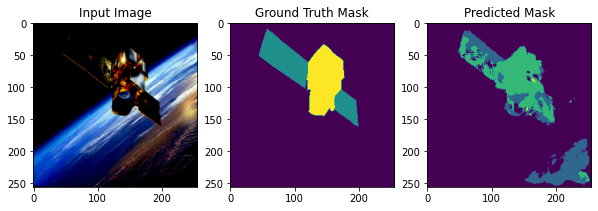

In [100]:

show_out(train,130)

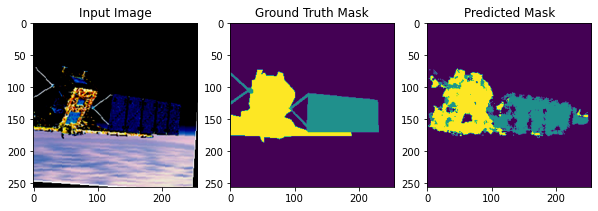

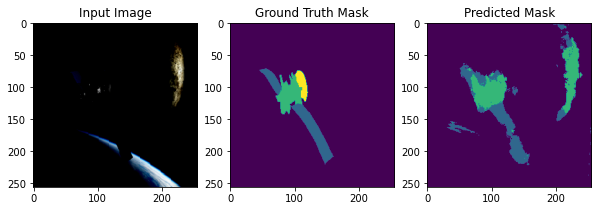

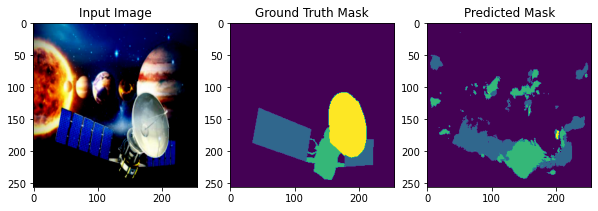

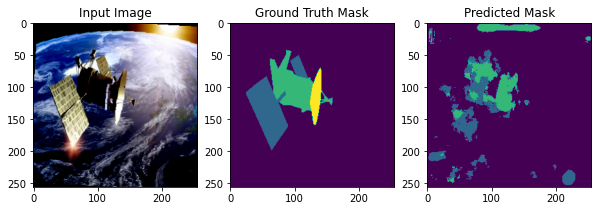

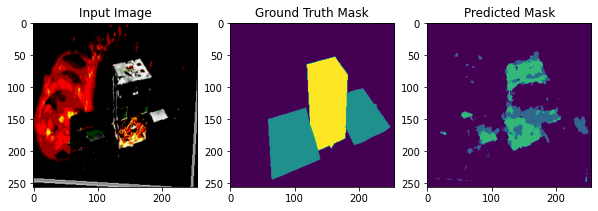

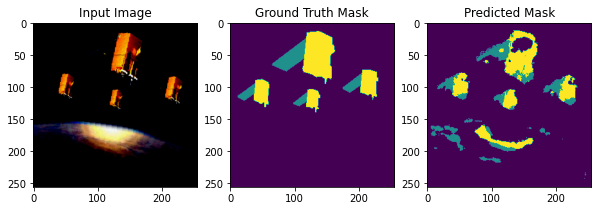

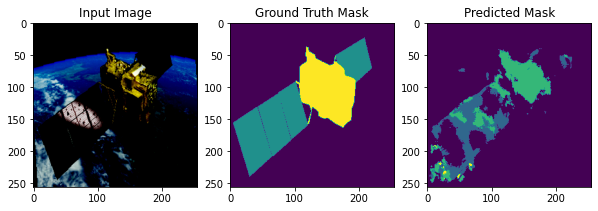

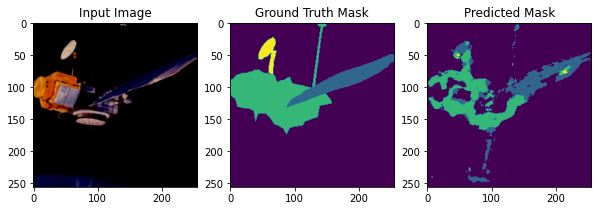

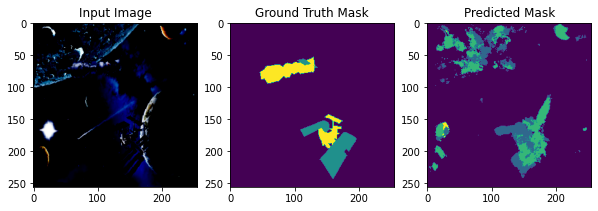

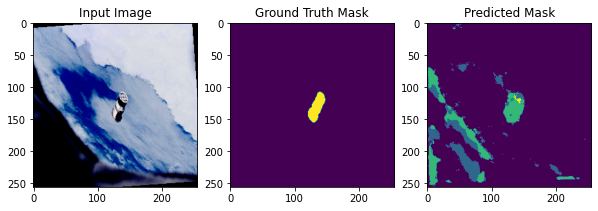

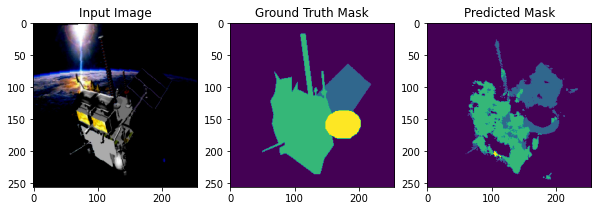

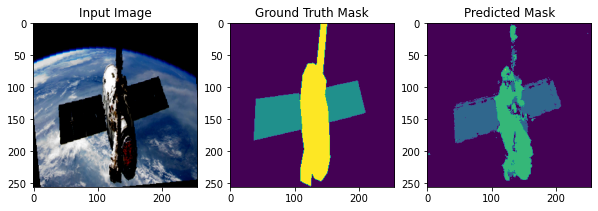

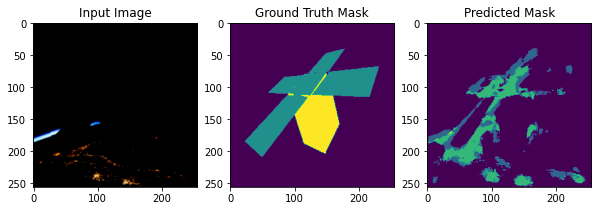

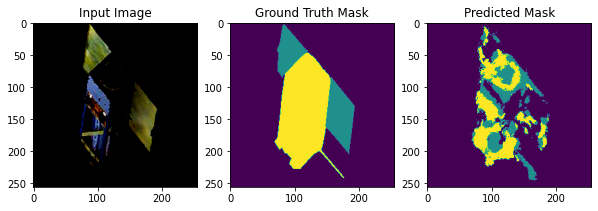

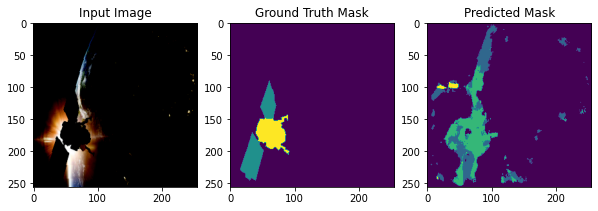

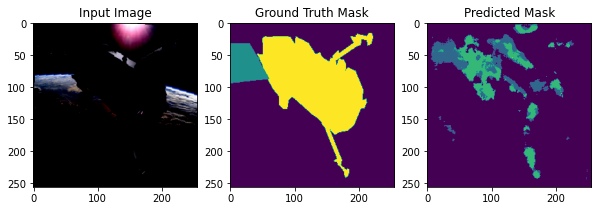

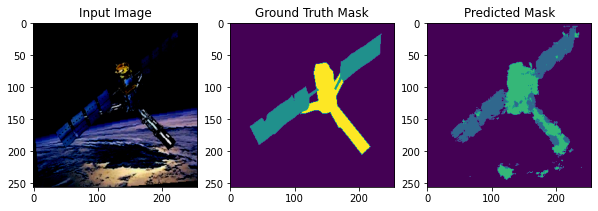

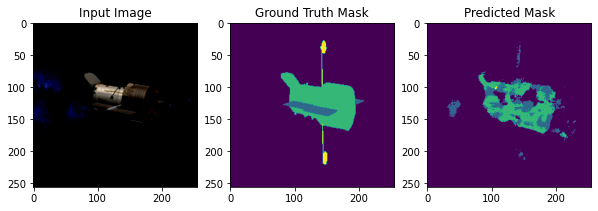

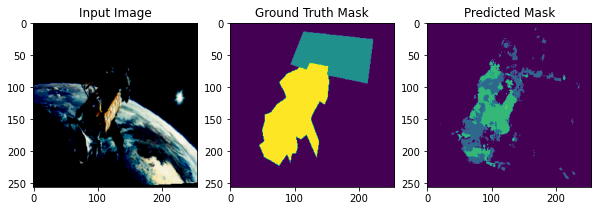

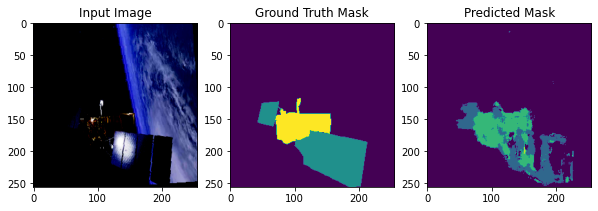

In [105]:
arr = np.random.randint(402, size=(20))
for x in arr:
  show_out(train,x)